In [131]:
# 一、安装基本的第三方包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm  # 快速的，易扩展的进度条提示模块
from sklearn.preprocessing import LabelEncoder  # 标签编码
from sklearn.feature_selection import SelectKBest  # 特征选择
from sklearn.feature_selection import chi2  # 卡方检验
from sklearn.feature_selection import VarianceThreshold  # 方差选择
from sklearn.feature_selection import RFE  # 特征递归消除
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression  # 逻辑回归
from sklearn.preprocessing import MinMaxScaler  # 特征缩放
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from scipy.stats import pearsonr  # 皮尔逊系数
from bayes_opt import BayesianOptimization  # 贝叶斯优化
import pandas_profiling
import pickle  # 数据持久化保存方式
import warnings
warnings.filterwarnings("ignore")  # 忽略警告
# 一、安装基本的第三方包

In [85]:
# 二、数据读取并查看
# 训练数据
data_train = pd.read_csv("/train.csv")
# 测试数据
data_test_a = pd.read_csv("/testA.csv")
# 查看数据
print("训练集数据：\n", data_train.shape)
print("测试集数据：\n", data_test_a.shape)
print("列名：\n", data_train.columns)
print("数据类型：\n", data_train.info())
print("特征基本统计：\n", data_train.describe())
# 查看缺失值、惟一值
print(f"训练集中有{data_train.isnull().any().sum()}列缺失值")

训练集数据：
 (800000, 47)
测试集数据：
 (200000, 46)
列名：
 Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64


In [4]:
# 生成数据报告
prf = pandas_profiling.ProfileReport(data_train)
prf.to_file("/Users/fangcheng/贷款违约预测/example.html")
# 生成数据报告

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
# 三、查看数值特征
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
catgory_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
# 三、查看数值特征

In [95]:
numerical_fea # 数值型

['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [50]:
catgory_fea # 对象型

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [51]:
# 划分数值型变量中的连续变量和离散型变量
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

In [52]:
# 连续变量
numerical_serial_fea

['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

In [53]:
# 离散型变量
numerical_noserial_fea

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

In [54]:
# 数值类型变量分析
print("term变量分布：\n",data_train['term'].value_counts())
print("homeOwnership变量分布：\n",data_train['homeOwnership'].value_counts())
print("verificationStatus变量分布：\n",data_train['verificationStatus'].value_counts())
print("isDefault变量分布：\n",data_train['isDefault'].value_counts())
print("initialListStatus变量分布：\n",data_train['initialListStatus'].value_counts())
print("applicationType变量分布：\n",data_train['applicationType'].value_counts())
print("policyCode变量分布：\n",data_train['policyCode'].value_counts())
print("n11变量分布：\n",data_train['n11'].value_counts())
print("n12变量分布：\n",data_train['n12'].value_counts())

term变量分布：
 3    606902
5    193098
Name: term, dtype: int64
homeOwnership变量分布：
 0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: homeOwnership, dtype: int64
verificationStatus变量分布：
 1    309810
2    248968
0    241222
Name: verificationStatus, dtype: int64
isDefault变量分布：
 0    640390
1    159610
Name: isDefault, dtype: int64
initialListStatus变量分布：
 0    466438
1    333562
Name: initialListStatus, dtype: int64
applicationType变量分布：
 0    784586
1     15414
Name: applicationType, dtype: int64
policyCode变量分布：
 1.0    800000
Name: policyCode, dtype: int64
n11变量分布：
 0.0    729682
1.0       540
2.0        24
4.0         1
3.0         1
Name: n11, dtype: int64
n12变量分布：
 0.0    757315
1.0      2281
2.0       115
3.0        16
4.0         3
Name: n12, dtype: int64


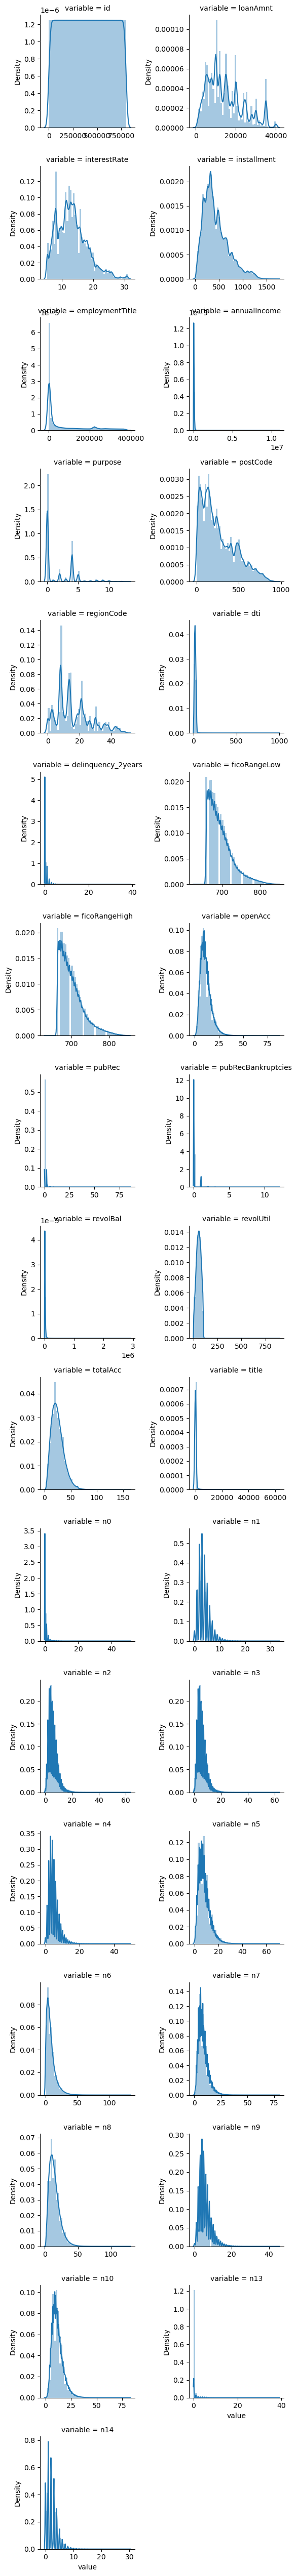

In [59]:
# 连续型变量分析
f = pd.melt(data_train, value_vars=numerical_serial_fea)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value") # 此处必须在第三方包中导入%matplotlib inline，或者调用sns.plt.show(),否则图会显示不出来

Text(0, 0.5, 'Probability')

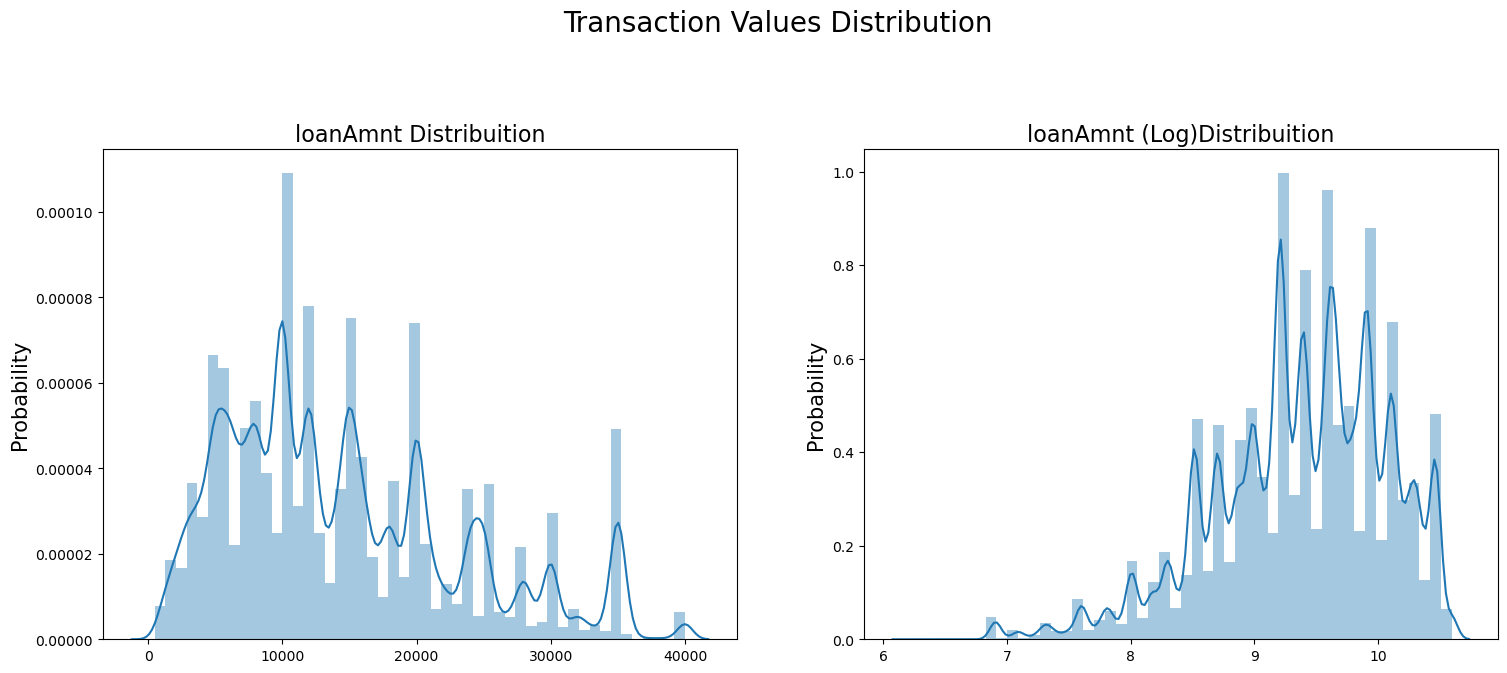

In [61]:
# 通过上述可视化可以看出，部分变量不符合正态分布，所以要把这部分的变量标准化
plt.figure(figsize=(18,14))
plt.suptitle('Transaction Values Distribution', fontsize=20)
plt.subplot(221)
sub_plot_1 = sns.distplot(data_train['loanAmnt'])
sub_plot_1.set_title("loanAmnt Distribuition", fontsize=16)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(data_train['loanAmnt']))
sub_plot_2.set_title("loanAmnt (Log)Distribuition", fontsize=16)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

In [63]:
# 非数值类型变量分析
print("grade变量分布：\n",data_train['grade'].value_counts())
print("subGrade变量分布：\n",data_train['subGrade'].value_counts())
print("employmentLength变量分布：\n",data_train['employmentLength'].value_counts())
print("issueDate变量分布：\n",data_train['issueDate'].value_counts())
print("earliesCreditLine变量分布：\n",data_train['earliesCreditLine'].value_counts())

grade变量分布：
 B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64
subGrade变量分布：
 C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64
employmentLength变量分布：
 10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: employmentLength, dtype: int64
issueDate变量分布：
 2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01    23245
2014-10-01    21461
              ... 

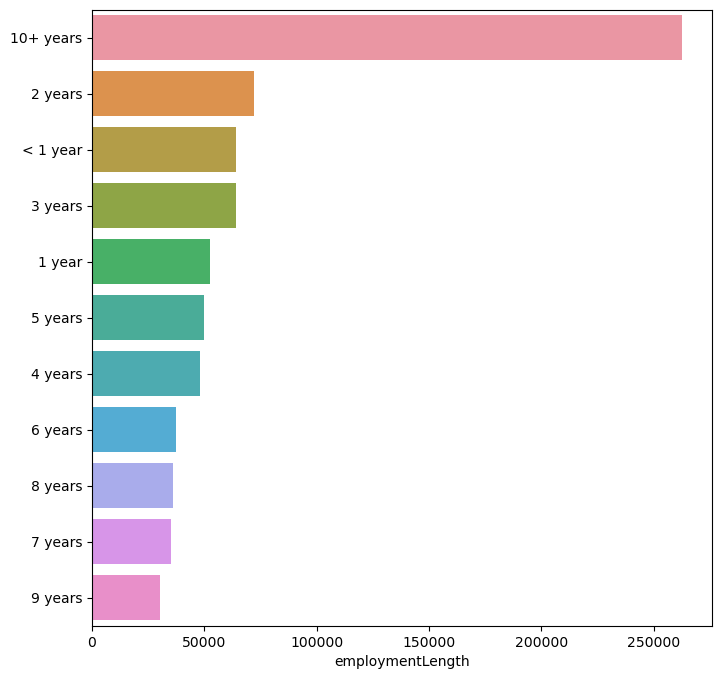

In [64]:
# 单一变量分布可视化
plt.figure(figsize=(8,8))
sns.barplot(data_train["employmentLength"].value_counts(dropna=False)[:20],data_train["employmentLength"].value_counts(dropna=False).keys()[:20])
plt.show()

In [65]:
# 类别型变量在不同y值上的分布
train_loan_fr = data_train.loc[data_train["isDefault"] == 1]
train_loan_nofr = data_train.loc[data_train["isDefault"] == 0]

<AxesSubplot:title={'center':'Count of employmentLength non-fraud'}, ylabel='employmentLength'>

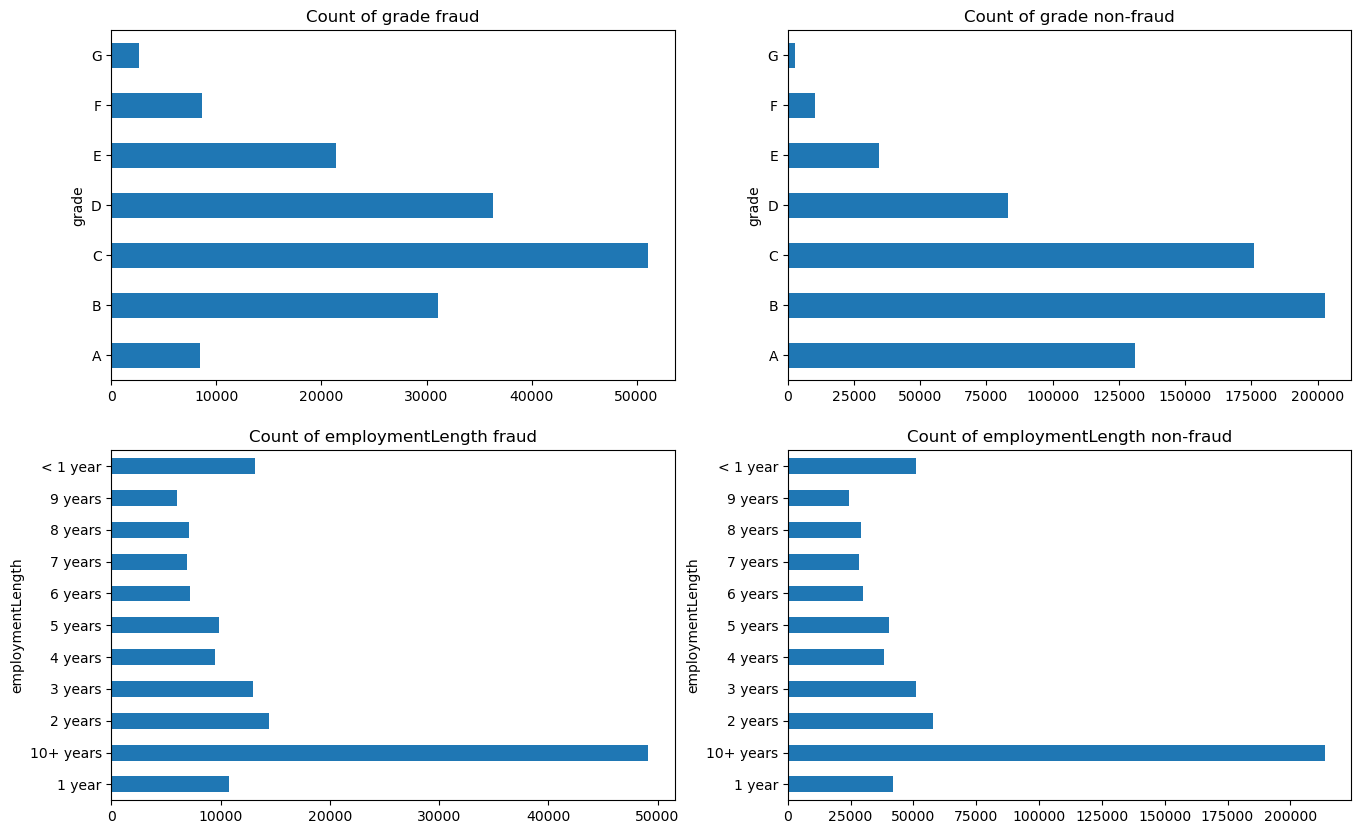

In [68]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(16,10))
train_loan_fr.groupby('grade')['grade'].count().plot(kind='barh',ax=ax1,title='Count of grade fraud')
train_loan_nofr.groupby('grade')['grade'].count().plot(kind='barh',ax=ax2,title='Count of grade non-fraud')
train_loan_fr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh',ax=ax3,title='Count of employmentLength fraud')
train_loan_nofr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh',ax=ax4,title='Count of employmentLength non-fraud')

<AxesSubplot:title={'center':'Log Loan Amt - Not Fraud'}, ylabel='Frequency'>

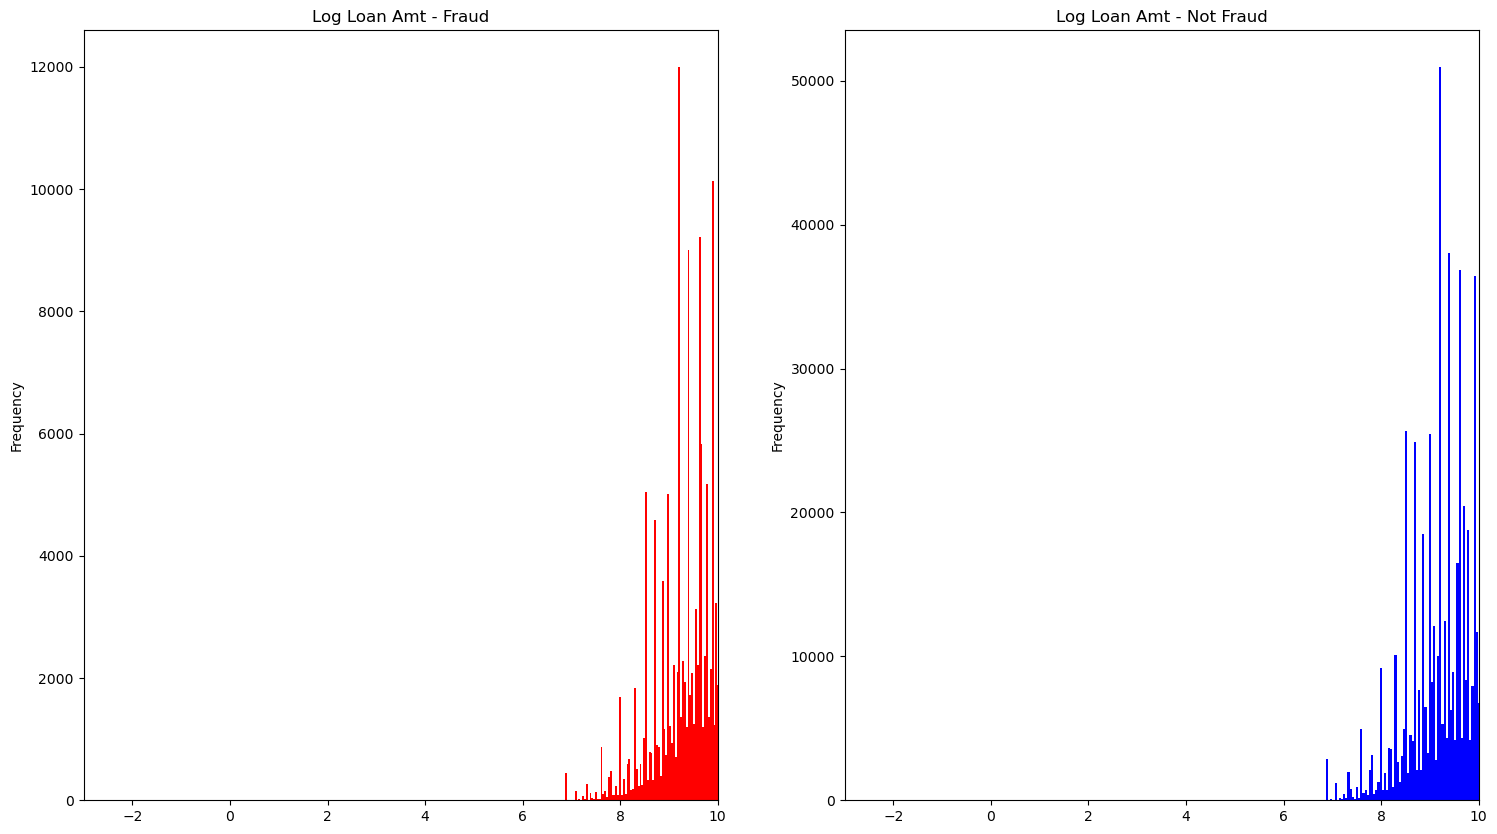

In [74]:
# 查看连续型变量在不同y值上的分布
fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(18,10))
data_train.loc[data_train['isDefault'] == 1]['loanAmnt'].apply(np.log).plot(kind='hist',bins=100,title='Log Loan Amt - Fraud',color='r',xlim=(-3,10),ax=ax1)
data_train.loc[data_train['isDefault'] == 0]['loanAmnt'].apply(np.log).plot(kind='hist',bins=100,title='Log Loan Amt - Not Fraud',color='b',xlim=(-3,10),ax=ax2)

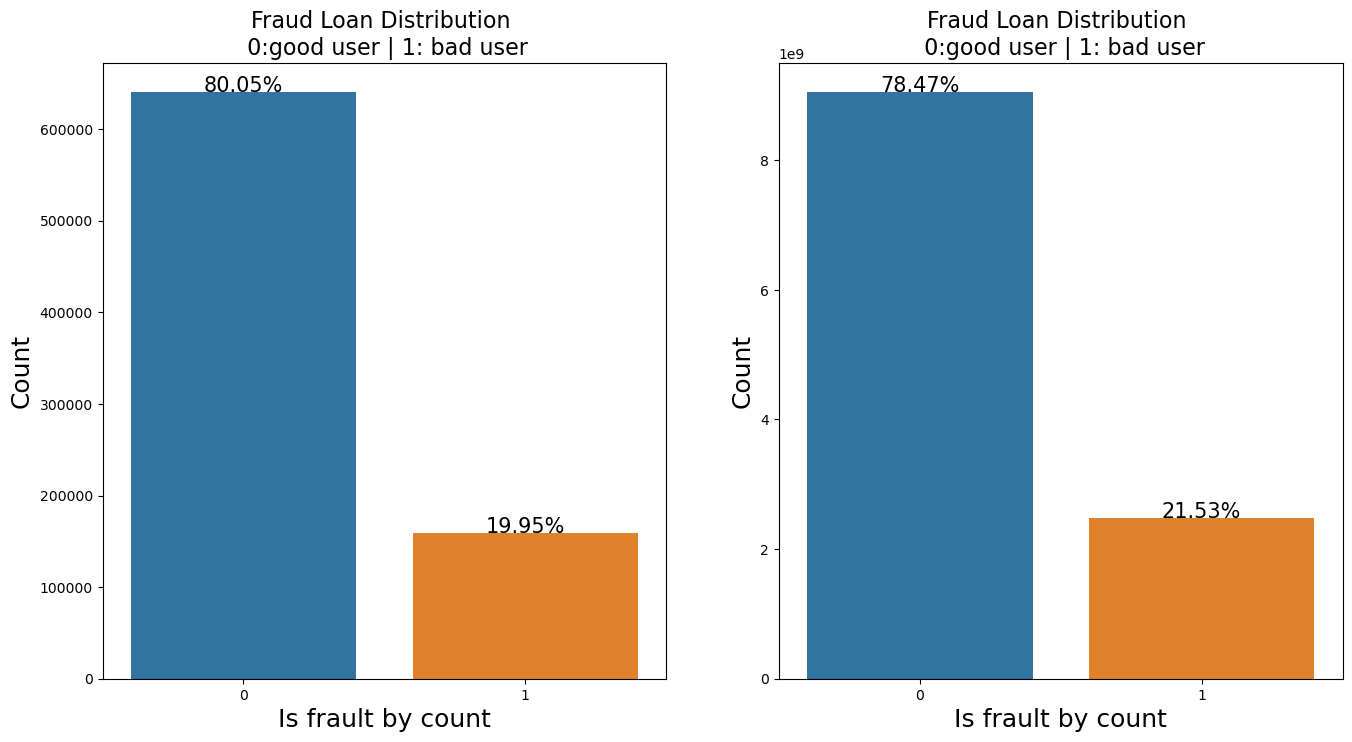

In [81]:
total = len(data_train)
total_amt = data_train.groupby(['isDefault'])['loanAmnt'].sum().sum()
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_tr = sns.countplot(x='isDefault',data=data_train)
plot_tr.set_title("Fraud Loan Distribution \n 0:good user | 1: bad user",fontsize=16)
plot_tr.set_xlabel("Is frault by count",fontsize=18)
plot_tr.set_ylabel("Count",fontsize=18)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=15)
    
    
percent_amt = data_train.groupby(['isDefault'])['loanAmnt'].sum()
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr2 = sns.barplot(x='isDefault',y='loanAmnt',dodge=True,data=percent_amt)
plot_tr2.set_title("Fraud Loan Distribution \n 0:good user | 1: bad user",fontsize=16)
plot_tr2.set_xlabel("Is frault by count",fontsize=18)
plot_tr2.set_ylabel("Count",fontsize=18)
for p in plot_tr2.patches:
    height = p.get_height()
    plot_tr2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=15)

In [89]:
# 时间格式数据处理
data_train['issueDate'] = pd.to_datetime(data_train['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01','%Y-%m-%d')
data_train['issueDateDT'] = data_train['issueDate'].apply(lambda x: x-startdate).dt.days

In [90]:
data_test_a['issueDate'] = pd.to_datetime(data_train['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01','%Y-%m-%d')
data_test_a['issueDateDT'] = data_test_a['issueDate'].apply(lambda x: x-startdate).dt.days

'训练集和测试集上的issueDateDT在日期上有重合，所以使用基于时间的分割进行验证不可行'

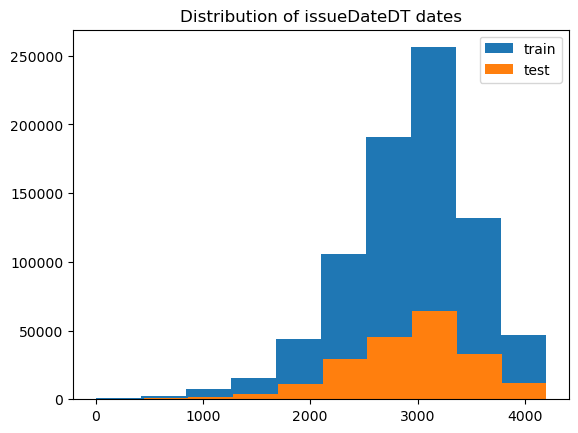

In [92]:
plt.hist(data_train['issueDateDT'], label='train')
plt.hist(data_test_a['issueDateDT'], label='test')
plt.legend()
plt.title('Distribution of issueDateDT dates')

'''训练集和测试集上的issueDateDT在日期上有重合，所以使用基于时间的分割进行验证不可行'''

In [93]:
# 数据透视：类似于Excel中的数据透视表
pivot = pd.pivot_table(data_train, index=['grade'],columns=['issueDateDT'], values=['loanAmnt'],aggfunc=np.sum)

In [94]:
pivot

loanAmnt                                                         \
issueDateDT     0        30       61       92       122      153       183    
grade                                                                         
A                NaN  53650.0  42000.0  19500.0  34425.0  63950.0   43500.0   
B                NaN  13000.0  24000.0  32125.0   7025.0  95750.0  164300.0   
C                NaN  68750.0   8175.0  10000.0  61800.0  52550.0  175375.0   
D                NaN      NaN   5500.0   2850.0  28625.0      NaN  167975.0   
E             7500.0      NaN  10000.0      NaN  17975.0   1500.0   94375.0   
F                NaN      NaN  31250.0   2125.0      NaN      NaN       NaN   
G                NaN      NaN      NaN      NaN      NaN      NaN       NaN   

                                           ...                          \
issueDateDT      214       245       274   ...        3926        3957   
grade                                      ...                           
A            168825.0   85600.0  101825.0  ...  13093850.0  11757325.0   
B            303175.0  434425.0  538450.0  ...  16863100.0  17275175.0   
C            151100.0  243725.0  393150.0  ...  17502375.0  17471500.0   
D            171325.0  192900.0  269325.0  ...  11403075.0  10964150.0   
E            116450.0   42000.0  139775.0  ...   3983050.0   3410125.0   
F             49000.0   27000.0   43000.0  ...   1074175.0    868925.0   
G             24625.0       NaN       NaN  ...     56100.0    243275.0   

                                                                       \
issueDateDT        3987        4018        4048       4079       4110   
grade                                                                   
A            11945975.0   9144000.0   7977650.0  6888900.0  5109800.0   
B            16217500.0  11431350.0   8967750.0  7572725.0  4884600.0   
C            16111225.0  11973675.0  10184450.0  7765000.0  5354450.0   
D            10747675.0   7082050.0   7189625.0  5195700.0  3455175.0   
E             3107150.0   2341825.0   2225675.0  1643675.0  1091025.0   
F              761675.0    685325.0    665750.0   685200.0   316700.0   
G              224825.0     64050.0    198575.0   245825.0    53125.0   

                                              
issueDateDT       4140       4171       4201  
grade                                         
A            3919275.0  2694025.0  2245625.0  
B            4329400.0  3922575.0  3257100.0  
C            4552600.0  2870050.0  2246250.0  
D            3038500.0  2452375.0  1771750.0  
E            1131625.0   883950.0   802425.0  
F             315075.0    72300.0        NaN  
G              23750.0    25100.0     1000.0  

[7 rows x 139 columns]

In [96]:
# 三、特征工程

In [97]:
# 特征预处理
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
catgory_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

In [98]:
# 查看缺失值，并且填充缺失值
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [99]:
# 按照众数填充类别
data_train[catgory_fea] = data_train[catgory_fea].fillna(data_train[catgory_fea].mode())
data_test_a[catgory_fea] = data_test_a[catgory_fea].fillna(data_test_a[catgory_fea].mode())


# 按照平均数填充连续值
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_test_a[numerical_fea].median())

In [100]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [101]:
catgory_fea

['grade', 'subGrade', 'employmentLength', 'earliesCreditLine']

In [102]:
# 对象型类别特征预处理，其中时间格式特征预先处理
for data in [data_train,data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01','%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [104]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [108]:
# 对象类型特征转换到数值
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train,data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years',value='10 years',inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years',inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [109]:
data['employmentLength'].value_counts(dropna=False).sort_index()

0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    65772
NaN     11742
Name: employmentLength, dtype: int64

In [110]:
# earliesCreditLine的预处理
data_train['earliesCreditLine'].sample(5)

500649    Nov-2004
302594    Jul-2003
531124    Nov-2001
540584    Sep-1998
491549    Sep-1996
Name: earliesCreditLine, dtype: object

In [111]:
for data in[data_train,data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [112]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 79282
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 889
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 12058
policyCode 类型数： 1


In [113]:
# 优先级的可以labelencode或者自映射
for data in [data_train,data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [114]:
# 类型数在2之上，又不是高维稀疏的,且纯分类特征
for data in [data_train, data_test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

In [115]:
# 检测异常值的方法一：均方差
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x: str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [117]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train =find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*15)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
***************
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
***************
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
***************
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
***************
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
***************
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
***************
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
****

In [ ]:
# 删除异常值
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliners']=='正常值']
    data_train = data_train.reset_index(drop=True)

In [121]:
# 检测异常值的方法二：箱型图
# 1、固定分箱
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

In [122]:
# 2、分为数分箱
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

In [123]:
# 特征交互
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [125]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [126]:
# 特征编码
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.08s/it]

Label Encoding 完成


In [152]:
data_train.head(15)

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,5,21,192025,2.0,2,110000.0,...,1.820574,3.980333,1.821304,3.863294,1.82198,3.863687,1.829339,3.85634,1.84548,3.899647
1,18000.0,5,18.49,461.9,4,16,104733,5.0,0,46000.0,...,1.458326,3.070714,1.457043,3.090635,1.457584,3.090949,1.463471,3.085072,1.476384,3.119718
2,12000.0,5,16.99,298.17,4,17,189509,8.0,0,74000.0,...,1.49359,3.014728,1.457043,3.090635,1.457584,3.090949,1.463471,3.085072,1.299807,3.019553
3,11000.0,3,7.26,340.96,1,3,249631,10.0,1,118000.0,...,0.36306,0.784788,0.364261,0.772659,0.364396,0.772737,0.365868,0.771268,0.391052,0.820342
4,3000.0,3,12.99,101.07,3,11,256267,10.0,1,29000.0,...,1.091589,2.314974,1.092782,2.317976,1.093188,2.318212,1.097603,2.313804,0.974855,2.264665
5,11000.0,3,7.99,344.65,1,4,254160,7.0,0,39000.0,...,0.365408,0.750126,0.364261,0.772659,0.364396,0.772737,0.365868,0.771268,0.419385,0.853507
6,2050.0,3,7.69,63.95,1,3,70697,9.0,0,35000.0,...,0.363863,0.771658,0.364261,0.772659,0.364396,0.772737,0.365868,0.771268,0.340512,0.767459
7,11500.0,3,14.98,398.54,3,12,99661,1.0,1,30000.0,...,1.08966,2.366998,1.092782,2.317976,1.093188,2.318212,1.097603,2.313804,1.107288,2.339788
8,12000.0,3,12.99,404.27,3,11,77517,5.0,2,60000.0,...,1.09867,2.287395,1.092782,2.317976,1.093188,2.318212,1.097603,2.313804,0.913091,2.229995
9,6500.0,3,10.99,212.78,2,8,256267,5.0,1,15300.0,...,0.72823,1.592133,0.728522,1.545317,0.728792,1.545475,0.731736,1.542536,0.569206,1.482269


In [127]:
# 逻辑回归等模型需要单独的特征工程
# 例如对特征做归一化

In [128]:
# 特征选择
'''
1、Filter：
    方差选择法
    相关系数法（皮尔逊系数）
    卡方检验
    互信息法
2、Wrapper（RFE）
    递归特征消除
3、Embedded
    基于惩罚项的特征选择
    基于树模型的特征选择
'''

'\n1、Filter：\n    方差选择法\n    相关系数法（皮尔逊系数）\n    卡方检验\n    互信息法\n2、Wrapper（RFE）\n    递归特征消除\n3、Embedded\n    基于惩罚项的特征选择\n    基于树模型的特征选择\n'

In [ ]:
# 方差选择
VarianceThreshold(threshold=3).fit_transform(train,trrget_train)

In [ ]:
# 相关系数
SelectKBest(k=5).fit_transform(train,target_train)

In [ ]:
# 卡方检验
SelectKBest(chi2,k=5).fit_transform(train,traget_train)

In [ ]:
# 互信息法
def mic(x,y):
    m = MINE()
    m.comput_score(x,y)
    return (m.mic(),0.5)
SelectKBest(lambda x ,y: array(map(lambda x:mic(x,Y),x.T)).T,k=2).fit_transform(train,traget_train)

In [ ]:
# 递归特征消除
RFE(estimator=LogisticRegression(),n_features_to_select=2).fit_transform(train,traget_train)

In [ ]:
# 基于惩罚项选择
SelectFromModel(LogisticRegression(penalty="l1", c=0.1)).fit_transform(train,traget_train)

In [ ]:
# 基于树模型选择
SelectFromModel(GradientBoostingClassifier()).fit_transform(train,traget_train)

In [ ]:
# 本数据集中删除不需要的数据
for data in [data_train,data_test_a]:
    data.drop(['issueDate', 'id'], axis=1,inplace=True)

In [149]:
# 纵向用缺失值上面的值替代
data_train = data_train.fillna(axis=1,method='ffill')

In [162]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

In [ ]:
x_train = data_train.drop(['isDefault','id'], axis=1)
#计算协方差
data_corr = x_train.corrwith(data_train.isDefault) 
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

In [ ]:
# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [163]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [164]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [ ]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

In [173]:
testA_result = pd.read_csv('/Users/fangcheng/贷款违约预测/train.csv')

In [ ]:
roc_auc_score(testA_result['isDefault'].values, lgb_test)

In [176]:
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [177]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
# 分离数据集，方便进行交叉验证
X_train = data.loc[data['sample']=='train', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
X_test = data.loc[data['sample']=='test', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
y_train = data.loc[data['sample']=='train', 'isDefault']

# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [ ]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

In [ ]:
"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [ ]:
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
        
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

In [ ]:
"""通过网格搜索确定最优参数"""
def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [ ]:
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 14,
                'max_depth': 19,
                'min_data_in_leaf': 37,
                'min_child_weight':1.6,
                'bagging_fraction': 0.98,
                'feature_fraction': 0.69,
                'bagging_freq': 96,
                'reg_lambda': 9,
                'reg_alpha': 7,
                'min_split_gain': 0.4,
                'nthread': 8,
                'seed': 2020,
                'silent': True,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=14269, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

In [ ]:
"""保存模型到本地"""
# 保存模型
import pickle
pickle.dump(final_model_lgb, open('dataset/model_lgb_best.pkl', 'wb'))